# Overview

This notebook demonstrates the methods we use to perform an analysis of dentist accessibility for youth in the state of Alabama.

The following code block imports the libraries that will be used.

In [1]:
import os

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',256)
import seaborn as sns
sns.set_style('whitegrid')

Our analysis focuses on answering two questions:
1. Assuming that the current group of dental care providers is practicing and will continue to practice, what is accessibility for youth by AL county?
2. Assuming that the current dental care providers retire at expected rates, with no new entrants, what is the impact on accessibility for youth by AL county?

We use the two-step floating catchment area method outlined in the paper Geographic access to dental care varies in Missouri and Wisconsin to answser the first question.
We use Monte Carlo simulation to answer the second question. The following code block specifies the number of replications that will be used for the simulation and also sets the random seed for the random number generator.

In [2]:
REPLICATIONS = 30
RANDOM_STATE = 0

### Helper function

The following code blocks defines a helper function, `apply_efficiency_map`, which applies an *efficiency map* to a specified column of a `pandas` `DataFrame` object that is passed as the first required argument and includes details on the age of providers. The *efficiency map* essentially captures the relative efficiency of the provider as a function of his/her age and is specified using a dictionary. By default, the function uses the mapper:

```python
efficiency_mapper = {
    (0, 55): 1.04,
    (55, 60): 1.03,
    (60, 64): 0.96,
    (64, 999): 0.82,
}
```

As you can see, the keys of the dictionary are tuples that map to possible age values. For example, the key (0, 55) will apply to providers whose age is greater than or equal to zero and less than 55, i.e., the right endpoint is not inclusive. The values associated with each key represent the relative efficiency of the age group, with higher values indicating higher efficency.

In [3]:
def apply_efficiency_map(provider_df, 
                         efficiency_mapper = {
                             (0, 55): 1.04,
                             (55, 60): 1.03,
                             (60, 64): 0.96,
                             (64, 999): 0.82,
                         },
                         column_to_map = 'Age_as_of_JUL2019',
                         return_column = 'Prov_Efficiency',
                        ):
    '''
    A helper function for mapping provider ages to efficiency scores. Returns a
    copy of df with a new column (return_column) that specifies the efficiency 
    score for all providers.
    
    Arguments:
    provider_df - a DataFrame with each row specifying the details for a single
        provider and at least one numeric column specifying each provider's age
    efficiency_mapper - a dictionary that specifies the efficiency mapping. The
        keys of the dictionary should be a tuple specifying the low and high
        age values for a particular efficiency value (the values in the dictionary).
        The default mapper is:
            efficiency_mapper = {
                (0, 55): 1.04,
                (55, 60): 1.03,
                (60, 64): 0.96,
                (64, 999): 0.82,
            }
        As an example, the key (0, 55) applies to providers whose age is greater than 
        or equal to zero and less than 55, i.e., the right endpoint is not inclusive.
    column_to_map - the numeric column including the age values
    return_column - specifies a new column name where the mapped efficiency values are
        stored in the returned copy of df            
    '''
    
    for key in efficiency_mapper.keys():
        mask = ((provider_df[column_to_map] >= key[0])
                & (provider_df[column_to_map] < key[1]))
        provider_df.loc[mask, return_column] = efficiency_mapper[key]
    
    return provider_df

# Data

Our primary analysis uses the following data sources:
1. Data regarding the youth population by census block in the state of Alabama (stored in `pop_table`),
2. Data regarding providers in the state of Alabama and bordering counties in other states (stored in `prov_table`),
3. Data regarding the distance and travel time between all provider locations and populated census blocks (stored in `matrix_table`), and
4. Data on historical retirement rates for dentists (stored in `exit_table`).

The following code block reads in the various data files and performs some basic modifications. Note that we specify a `retirement_date_range` parameter. This parameter is used to identify the date range for retirment rates that we want to use from the `exit_table`.

In [5]:
# read table including population information
# and fill spaces in column names with underscores
pop_table = pd.read_pickle('data/pop_table.pkl.gz')
print('Population table read')

# read table including provider information
# and fill spaces in column names with underscores
prov_table = pd.read_pickle('data/prov_table.pkl.gz')
print('Provider table read')

# read table including distance information
# and fill spaces in column names with underscores
matrix_table = pd.read_pickle('data/matrix_table.pkl.gz')
print('Distance matrix read')

# read in data dictionary table
data_dict_table = pd.read_pickle('data/data_dict_table.pkl.gz')
data_dict_table['Variable_Name'] = data_dict_table['Variable_Name'].str.replace(' ', '_')
data_dict_table = data_dict_table.drop(columns = ['Index'])
print('Data dictionary read')

# The following lines identify providers that are in
# both the distance table and the provider information
# table. We remove any providers from these tables that
# do not appear in both.
matrix_providers = matrix_table['Prov_ID'].unique().tolist()
prov_table_providers = prov_table['Prov_ID'].unique().tolist()
common_providers = set(matrix_providers).intersection(set(prov_table_providers))
common_providers = list(common_providers)
prov_table = prov_table[prov_table['Prov_ID'].isin(common_providers)]
matrix_table = matrix_table[matrix_table['Prov_ID'].isin(common_providers)]
print('matrix_table and prov_table restricted to common providers')

# apply efficiency mapping to prov_table
prov_table = apply_efficiency_map(prov_table)
print('Provider efficency mapped to prov_table')

# get list of all columns
all_columns = list(set(prov_table.columns.tolist()
                       + matrix_table.columns.tolist()
                       + pop_table.columns.tolist()))

# remove any columns not in data from data dictionary
data_dict_table = data_dict_table[data_dict_table['Variable_Name'].isin(all_columns)].reset_index(drop = True)

# map data dictionary table names to variables
table_mapper = {
    'dbo.AL_Active_Dentists': 'prov_table',
    'dbo.AL_Pop': 'pop_table',
    'dbo.Gen_Dental_Matrix': 'matrix_table',
    'dbo.Dental_Exit_Rate': 'exit_table',
}
data_dict_table['table'] = data_dict_table['table'].map(table_mapper)

data_dict_table

Population table read
Provider table read
Distance matrix read
Data dictionary read
matrix_table and prov_table restricted to common providers
Provider efficency mapped to prov_table


,Variable_Name,dtype,Desc,table
0,Prov_ID,int64,Assigned provider ID,prov_table
1,Age_as_of_JUL2019,int64,"Age (in years) of provider as of July 1, 2019",prov_table
2,GEOID,object,US Census Assigned ID for respective Block Group,pop_table
3,Total_Youth_Pop,float64,Total youth population from columns: Male_Youth_Pop+Female_Youth_Pop,pop_table
4,COUNTYFP,object,Three digit US Census county identifier,pop_table
5,GEOID,object,US Census Assigned ID for respective Block Group from population table,matrix_table
6,Prov_ID,int64,Provider ID from provider table,matrix_table
7,Total_Minutes,float64,Estimated automobile travel time it takes to travel from population Block Group centroid to provider location,matrix_table


The following code uses a binomial value to determine whether or not a dental provider retired in that particular simulation.

In [6]:
base_cols = prov_table.columns.tolist()
np.random.seed(RANDOM_STATE)
sim_columns = [f'sim{i+1}' for i in range(REPLICATIONS)]
sim_vals = np.random.binomial(
    n = 1,
    p = prov_table['Retention_Rate'],
    size = (REPLICATIONS, prov_table.shape[0])
)
sim_vals = sim_vals.T
prov_table = prov_table.join(pd.DataFrame(sim_vals))
prov_table.columns = base_cols + sim_columns

matrix_table = matrix_table.merge(
    pop_table[['Total_Youth_Pop','GEOID']], 
    left_on = ['GEOID'], 
    right_on = ['GEOID']
).merge(
    prov_table[['Prov_ID', 'Prov_Efficiency'] + sim_columns], 
    left_on = ['Prov_ID'], 
    right_on = ['Prov_ID']
)

matrix_table.head()

,GEOID,Prov_ID,Total_Minutes,Total_Youth_Pop,Prov_Efficiency,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9,sim10,sim11,sim12,sim13,sim14,sim15,sim16,sim17,sim18,sim19,sim20,sim21,sim22,sim23,sim24,sim25,sim26,sim27,sim28,sim29,sim30
0,010010201001,4,90.661117,188.0,1.03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,010010201002,4,89.436192,290.0,1.03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,010010202001,4,86.584428,353.0,1.03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,010010202002,4,88.083864,264.0,1.03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,010010203001,4,88.425708,697.0,1.03,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


https://onlinelibrary.wiley.com/doi/full/10.1111/jphd.12197

The two-step floating catchment area (2SFCA) method involves two major steps. The first step involves calculating an initial provider to population for each of the providers. This is calculated and stored as the initial ratio in a temp dataframe. These initial ratios are then mapped to their corresponding provider ids in the distance matrix in order to prepare for the next step. Step two of the 2SFCA involves aggregating the ratios of each of the providers with respect to a particular population block. The result is the accessability score for a that population block and is the output of the following function.

In [7]:
def apply_F2PCA(distance_table,
                population_table,
                cutoff = 30,
                include_plot = False,
                efficiency_mapper = {
                    (0, 55): 1.04,
                    (55, 60): 1.03,
                    (60, 64): 0.96,
                    (64, 999): 0.82,
                }):
    '''
    apply_F2PCA utilizes the data provided to create an accessability score for a particular GEOID. 
    
    Outputs
    Returns a dataframe with the accessability scores for a particular GEOID and has the option to output a histogram
    plot of the accessability data.
    
    Inputs
    distance_table: The distance table refers to the matix table above and should include the following columns in order
    to function properly
    
                Total Minutes   : Total minutes refers to the amount of travel time it takes to go between a GEOID and
                a Prov_ID.
                GEOID           : The unique identification number of a population block.
                Prov_ID         : The unique identification number of a dental provider.
                Prov_Efficiency : The FTE (Full Time Equivalent) value of a provider.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                
    population_table: The population table refers to the population table above and should include the following columns in order
    to function properly and is used display the final results
    
                GEOID           : The unique identification number of a population block.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                COUNTYFP        : The unique identification number of a county in Alabama.
                
    cutoff: Default set to 30 minutes. The cutoff is the amount of time a person is willing to travel before they decide to quit looking
    for a dental provider. Value is in minutes.
    
    include_plot: Boolean. Adds a histogram plot with the score as the x-axis and the frequency as the y-axis.
    efficiency_mapper: A dictionary with the age ranges and their corresponding efficiencie (FTE) values
    
    '''

    import time
    start = time.time()
    
    distance_mask = distance_table['Total_Minutes'] <= cutoff
    distance_table = distance_table[distance_mask]
    #Step 1
    temp = distance_table.groupby(['Prov_ID','Prov_Efficiency'])['Total_Youth_Pop'].sum()
    temp = temp.reset_index()
    temp['Initial_Ratio'] = temp.eval('Prov_Efficiency/Total_Youth_Pop')*1000
    prov_to_ratio_mapper = temp.set_index('Prov_ID')['Initial_Ratio'].to_dict()
    
    distance_table['Initial_Ratio'] = distance_table['Prov_ID'].map(prov_to_ratio_mapper)
    #Step 2
    GEOID_to_score_mapper = distance_table.groupby('GEOID')['Initial_Ratio'].sum().to_dict()
    population_table.loc[:, 'Score'] = population_table['GEOID'].map(GEOID_to_score_mapper).fillna(0)
    
    print(f'Completed in {np.round(time.time() - start, 3)} seconds')
    
    if include_plot:
        import matplotlib.pyplot as plt
        import warnings
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            fig, ax = plt.subplots(1, 1, figsize = (8, 5))
            ax.hist(
                population_table['Score'].values,
                edgecolor = 'k',
                bins = 20,
            )

            plt.show()
    
    return population_table

Completed in 1.011 seconds


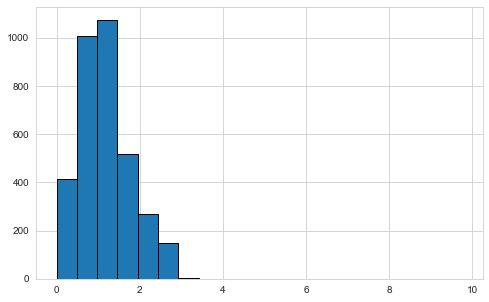

,GEOID,Total_Youth_Pop,COUNTYFP,Score
0,010010201001,188.0,001,0.737790
1,010010201002,290.0,001,0.323221
2,010010202001,353.0,001,0.702847
3,010010202002,264.0,001,0.751549
4,010010203001,697.0,001,0.681112
...,...,...,...,...
3432,011339658004,239.0,133,0.739654
3433,011339658005,299.0,133,0.564001
3434,011339659001,185.0,133,0.676255
3435,011339659002,258.0,133,1.320463


In [8]:
apply_F2PCA(matrix_table, pop_table, include_plot = True)

In [9]:
def apply_F2PCA_sim(distance_table,
                    population_table,
                    cutoff = 30,
                    efficiency_mapper = {
                        (0, 55): 1.04,
                        (55, 60): 1.03,
                        (60, 64): 0.96,
                        (64, 999): 0.82,
                    }):
    '''
 apply_F2PCA_sim creates simulated accessability scores based off whether a provider was to retire or not and how that
 effects the accessability for each population block.

 Outputs
     Outputs a dataframe with the original accessability score and the simulated accessability scores if some providers were
     to retire.
 Inputs
    distance_table: The distance table refers to the matix table above and should include the following columns in order
    to function properly
    
                Total Minutes   : Total minutes refers to the amount of travel time it takes to go between a GEOID and
                a Prov_ID.
                GEOID           : The unique identification number of a population block.
                Prov_ID         : The unique identification number of a dental provider.
                Prov_Efficiency : The FTE (Full Time Equivalent) value of a provider.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                
    population_table: The population table refers to the population table above and should include the following columns in order
    to function properly and is used display the final results
    
                GEOID           : The unique identification number of a population block.
                Total_Youth_Pop : The summed population of youth for a particular GEOID
                COUNTYFP        : The unique identification number of a county in Alabama.
    cutoff: Default set to 30 minutes. The cutoff is the amount of time a person is willing to travel before they decide to quit looking
    for a dental provider. Value is in minutes.
                        
    '''

    import time
    start = time.time()
    #Step 1
    distance_mask = distance_table['Total_Minutes'] <= cutoff
    distance_table = distance_table[distance_mask]

    temp = distance_table.groupby(['Prov_ID','Prov_Efficiency'])['Total_Youth_Pop'].sum()
    temp = temp.reset_index()
    temp['Initial_Ratio'] = (temp['Prov_Efficiency']/temp['Total_Youth_Pop'])*1000
    prov_to_ratio_mapper = temp.set_index('Prov_ID')['Initial_Ratio'].to_dict()
    distance_table['Initial_Ratio'] = distance_table['Prov_ID'].map(prov_to_ratio_mapper)
    #Collect simulated retirement value from the distance table
    sim_columns = [col for col in distance_table.columns if col.startswith('sim')]
    distance_table[sim_columns] = distance_table[sim_columns].multiply(
        distance_table['Initial_Ratio'], 
        axis = 'index'
    )
    #Step 2
    GEOID_to_score_mapper = distance_table.groupby('GEOID')[sim_columns].sum()
    GEOID_to_score_mapper['values'] = GEOID_to_score_mapper.values.tolist()
    GEOID_to_score_mapper = GEOID_to_score_mapper['values'].to_dict()

    temp = pd.DataFrame.from_dict(GEOID_to_score_mapper).transpose()
    temp.columns = sim_columns
    temp = temp.reset_index()
    temp = temp.rename(columns = {'index': 'GEOID'})
    population_table = population_table.merge(temp, how = 'left')
    population_table.loc[:, sim_columns] = population_table.loc[:, sim_columns].fillna(0)
    
    print(f'Completed in {np.round(time.time() - start, 3)} seconds')
    
    return population_table

In [10]:
sim_results = apply_F2PCA_sim(matrix_table, pop_table)
sim_results.head()

Completed in 0.662 seconds


,GEOID,Total_Youth_Pop,COUNTYFP,Score,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9,sim10,sim11,sim12,sim13,sim14,sim15,sim16,sim17,sim18,sim19,sim20,sim21,sim22,sim23,sim24,sim25,sim26,sim27,sim28,sim29,sim30
0,010010201001,188.0,001,0.737790,0.642090,0.561402,0.629104,0.590844,0.618024,0.637871,0.618727,0.500072,0.620620,0.604257,0.645604,0.615549,0.610057,0.553261,0.535961,0.578549,0.645771,0.560285,0.500998,0.561724,0.606640,0.650392,0.594604,0.643778,0.547798,0.589421,0.655863,0.641729,0.594653,0.631557
1,010010201002,290.0,001,0.323221,0.248372,0.261532,0.258931,0.233952,0.251440,0.268234,0.272238,0.222643,0.250351,0.247037,0.276892,0.270488,0.296278,0.208294,0.258296,0.259946,0.297862,0.248766,0.221422,0.246517,0.295040,0.283289,0.261410,0.300102,0.294685,0.288961,0.276973,0.271910,0.259517,0.298924
2,010010202001,353.0,001,0.702847,0.603366,0.583538,0.606351,0.555901,0.595271,0.602928,0.583785,0.545544,0.584108,0.569314,0.632829,0.602774,0.597281,0.543866,0.580265,0.556964,0.607047,0.535320,0.523135,0.593838,0.628777,0.627639,0.568069,0.634383,0.592102,0.562886,0.620920,0.616764,0.571900,0.622161
3,010010202002,264.0,001,0.751549,0.642090,0.575161,0.642863,0.604603,0.631783,0.651630,0.632487,0.513832,0.620620,0.618016,0.659363,0.629308,0.623816,0.567020,0.549720,0.592308,0.645771,0.574044,0.514757,0.575483,0.620399,0.664151,0.594604,0.657537,0.561557,0.589421,0.669622,0.655488,0.608412,0.645316
4,010010203001,697.0,001,0.681112,0.571654,0.561803,0.572426,0.534166,0.561346,0.581193,0.562050,0.513832,0.550183,0.547579,0.588927,0.558872,0.553379,0.509941,0.536363,0.535229,0.575334,0.503607,0.501400,0.562126,0.607042,0.593714,0.524167,0.600458,0.548199,0.518984,0.599185,0.585051,0.537975,0.588237


## Interactive Data

In the following code blocks county codes and data is taken in and mergeed with the simulation in order to map the results to the county level.

In [11]:
# from https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
county_mapper = pd.read_excel(
    'data/county_codes.xlsx',
    skiprows = 4,
    dtype = 'object'
)

AL_mask = county_mapper['State Code (FIPS)'] == '01'
county_mask = county_mapper['Summary Level'] == '050'
county_mapper = county_mapper[(AL_mask &  county_mask)]

county_mapper['Area Name (including legal/statistical area description)'] \
= county_mapper['Area Name (including legal/statistical area description)'].str.replace(' County', '')

county_mapper = county_mapper.set_index('County Code (FIPS)')
county_mapper = county_mapper['Area Name (including legal/statistical area description)']
county_mapper = county_mapper.to_dict()
print('County FIP -> County mapper created')

County FIP -> County mapper created


The following code block consolidates the data with each county to form the analysis at the county level. The results of the simulation are shown below and correspond to the 30 minute travel distance cutoff time. The x-axis is the mean accessability score for a particular county and can be thought of as how affective are current providers are at providing accessability to population blocks. In general, the higher the mean accessability score is, the better level of spatial access for a particular county population. The y-axis is the standard deviation between simulation accessability scores and can be thought of as how sensitive a county is to a retirement/loss of a provider. The higher the standard deviation, more sensitive a county's population is to changes in accessability due to the loss of a provider.

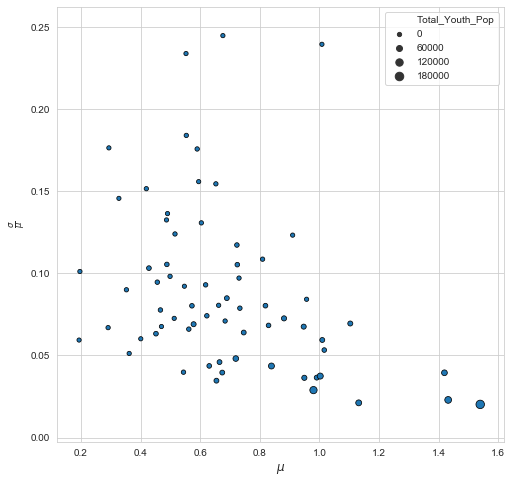

In [12]:
temp = sim_results.copy()
temp['County'] = temp['COUNTYFP'].map(county_mapper)
temp['County_Sum'] = temp.groupby('County')['Total_Youth_Pop'].transform('sum')
temp['GEOID_Prop'] = temp['Total_Youth_Pop']/temp['County_Sum']
sim_columns = [col for col in temp.columns if col.startswith('sim')]
temp[sim_columns] = temp[sim_columns].multiply(temp['GEOID_Prop'], axis = 'index')
temp = temp.groupby('County')[sim_columns + ['Total_Youth_Pop']].sum()
temp['County_Mean'] = temp[sim_columns].mean(axis = 1)
temp['County_Std'] = temp[sim_columns].std(ddof = 1, axis = 1)
temp['County_CV'] = temp['County_Std']/temp['County_Mean'] 

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

sns.scatterplot(x = 'County_Mean',
                y = 'County_CV',
                size = temp['Total_Youth_Pop'],
                edgecolor = 'k',
                data = temp)

ax.set_xlabel(r'$\mu$', fontsize = 12)
ax.set_ylabel(r'$\frac{\sigma}{\mu}$', fontsize = 12)

plt.show()

In [13]:
from sklearn.cluster import KMeans

def interactive_plot1(cutoff_val, nclusters):

    sim_results = apply_F2PCA_sim(
        matrix_table, 
        pop_table, 
        cutoff = cutoff_val
    )
    
    temp = sim_results.copy()
    temp['County'] = temp['COUNTYFP'].map(county_mapper)
    temp['County_Sum'] = temp.groupby('County')['Total_Youth_Pop'].transform('sum')
    temp['GEOID_Prop'] = temp['Total_Youth_Pop']/temp['County_Sum']
    sim_columns = [col for col in temp.columns if col.startswith('sim')]
    temp[sim_columns] = temp[sim_columns].multiply(temp['GEOID_Prop'], axis = 'index')
    temp = temp.groupby('County')[sim_columns + ['Total_Youth_Pop']].sum()
    temp['County_Mean'] = temp[sim_columns].mean(axis = 1)
    temp['County_Std'] = temp[sim_columns].std(ddof = 1, axis = 1)
    temp['County_CV'] = (temp['County_Std']/temp['County_Mean']).fillna(0) 
    
    temp_knn_model = KMeans(
        n_clusters = nclusters,
        random_state = 0,
        max_iter = 1000,
    )

    knn_array = temp[['County_Mean', 'County_CV']]
    kmeans_fit = temp_knn_model.fit(knn_array)
    temp['Cluster'] = kmeans_fit.predict(knn_array)

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    sns.scatterplot(x = 'County_Mean',
                    y = 'County_CV',
                    size = 'Total_Youth_Pop',
                    edgecolor = 'k',
                    hue = 'Cluster',
                    data = temp)

    ax.set_title(f'Scatterplot for Cutoff of {cutoff_val} Minutes',
                 fontsize = 14)
    ax.set_xlabel(r'$\mu$', fontsize = 16)
    ax.set_ylabel(r'$\frac{\sigma}{\mu}$', fontsize = 16)

    plt.show()

In [14]:
interact(interactive_plot1, 
         cutoff_val = [10, 15, 30, 60, 120], 
         nclusters = widgets.IntSlider(min=2, max=10, step=1, value=3));

interactive(children=(Dropdown(description='cutoff_val', options=(10, 15, 30, 60, 120), value=10), IntSlider(v…